In [109]:
from pandas import read_excel, DataFrame, merge, get_dummies,concat
from statsmodels.formula.api import logit
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, recall_score, precision_score, f1_score
import seaborn as sb
from matplotlib import pyplot as plt
import numpy as np
import sys
import os
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))
from helper import my_logit,scailing,is_categorical

## 문제 1

피마 인디언 당뇨병 발병여부를 예측할 수 있는 분석 모델을 구현하기 위해 아래와 같은 항목들을 조사하였다. 분석하라

In [110]:
df = read_excel("https://data.hossam.kr/E05/indian_diabetes.xlsx")
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [111]:
model = logit('Outcome~ Pregnancies+Glucose+BloodPressure+SkinThickness+Insulin+BMI+DiabetesPedigreeFunction+Age', data=df)
fit = model.fit()
print(fit.summary())

Optimization terminated successfully.
         Current function value: 0.470993
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                Outcome   No. Observations:                  768
Model:                          Logit   Df Residuals:                      759
Method:                           MLE   Df Model:                            8
Date:                Tue, 01 Aug 2023   Pseudo R-squ.:                  0.2718
Time:                        16:54:16   Log-Likelihood:                -361.72
converged:                       True   LL-Null:                       -496.74
Covariance Type:            nonrobust   LLR p-value:                 9.652e-54
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -8.4047      0.717    -11.728      0.000      -9.809

In [112]:
fit.prsquared

0.27180966859224587

In [113]:
df['예측값'] =fit.predict(df.drop('Outcome', axis =1))
df['예측결과']  = df['예측값'] > 0.5
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,예측값,예측결과
0,6,148,72,35,0,33.6,0.627,50,1,0.721727,True
1,1,85,66,29,0,26.6,0.351,31,0,0.048642,False
2,8,183,64,0,0,23.3,0.672,32,1,0.796702,True
3,1,89,66,23,94,28.1,0.167,21,0,0.041625,False
4,0,137,40,35,168,43.1,2.288,33,1,0.902184,True
...,...,...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0,0.317115,False
764,2,122,70,27,0,36.8,0.340,27,0,0.318969,False
765,5,121,72,23,112,26.2,0.245,30,0,0.170416,False
766,1,126,60,0,0,30.1,0.349,47,1,0.284976,False


In [114]:
cm = confusion_matrix(df['Outcome'],df['예측결과'])
tn, fp, fn, tp = cm.ravel()
cmdf = DataFrame([[tn, tp], [fp, fn]], index=['True', 'False'], columns=['Negative', 'Positive'])
cmdf

,Negative,Positive
True,445,156
False,55,112


 ROC curve 실사화

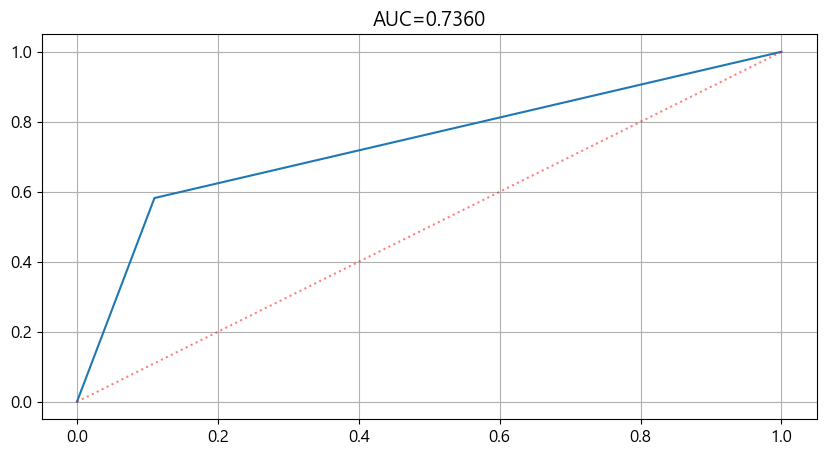

In [115]:
ras = roc_auc_score(df['Outcome'],df['예측결과'])

# 위양성을 재현율 임계값(사용안함)
fpr,tpr,threshold = roc_curve(df['Outcome'],df['예측결과'])

plt.figure()
sb.lineplot(x=fpr, y= tpr)
sb.lineplot(x=[0,1], y=[0,1],color = 'red', linestyle=':', alpha = 0.5)
plt.title('AUC={:.4f}'.format(ras))
plt.grid()
plt.show()
plt.close()

In [116]:
acc = accuracy_score(df['Outcome'], df['예측결과'])

pre = precision_score(df['Outcome'], df['예측결과'])

recall = recall_score(df['Outcome'], df['예측결과'])

f1 = f1_score(df['Outcome'], df['예측결과'])

fallout = fp/(fp+tn)

spe = 1- fallout

result_df = DataFrame({"설명력(Pseudo-Rsqe)":[fit.prsquared], "정확도(Accuracy)":[acc], "정밀도(Precision)":[pre], '재현율(Recall, TPR)':[recall], '위양성율(Fallout, FPR)': [fallout], '특이성(Specificity, TNR)':[spe], 'RAS': [ras], 'f1_score':[f1]})
result_df

,설명력(Pseudo-Rsqe),정확도(Accuracy),정밀도(Precision),"재현율(Recall, TPR)","위양성율(Fallout, FPR)","특이성(Specificity, TNR)",RAS,f1_score
0,0.27181,0.782552,0.739336,0.58209,0.11,0.89,0.736045,0.651357


In [117]:
coef = fit.params
coef

Intercept                  -8.404696
Pregnancies                 0.123182
Glucose                     0.035164
BloodPressure              -0.013296
SkinThickness               0.000619
Insulin                    -0.001192
BMI                         0.089701
DiabetesPedigreeFunction    0.945180
Age                         0.014869
dtype: float64

In [118]:
odds_rate = np.exp(coef)
odds_rate

Intercept                   0.000224
Pregnancies                 1.131091
Glucose                     1.035789
BloodPressure               0.986792
SkinThickness               1.000619
Insulin                     0.998809
BMI                         1.093847
DiabetesPedigreeFunction    2.573276
Age                         1.014980
dtype: float64

당뇨 내력 가중치가 가장 당뇨병 발현에 연관이 깊고 그렇지 않은 경우보다 2.5배 이상이다.

# 문제 2
다음의 데이터는 타이타닉 탑승객 명단 데이터이다. 적절한 데이터 전처리와 정제를 수행한 후 분석하라.

In [119]:
df2 = read_excel("https://data.hossam.kr/E05/titanic.xlsx")
df2

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [120]:
model = logit("Survived~ Pclass+Sex+Age+Age+SibSp+Parch+Fare+Embarked", data = df2)
fit = model.fit()
summary = fit.summary()
summary

Optimization terminated successfully.
         Current function value: 0.444061
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      703
Method:                           MLE   Df Model:                            8
Date:                Tue, 01 Aug 2023   Pseudo R-squ.:                  0.3419
Time:                        16:54:17   Log-Likelihood:                -316.17
converged:                       True   LL-Null:                       -480.45
Covariance Type:            nonrobust   LLR p-value:                 3.392e-66
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         5.6374      0.635      8.884      0.000       4.394       6.881
Sex[T.male]      -2.6385      0.222    -11.871      0.000      -3.074      -2.203
Embarked[T.Q]    -0.8235      0.600     -1.372      0.170      -2.000       0.353
Embarked[T.S]    -0.4012      0.270     -1.484      0.138      -0.931       0.129
Pclass           -1.1993      0.165     -7.285      0.000      -1.522      -0.877
Age              -0.0433      0.008     -5.266      0.000      -0.059      -0.027
SibSp            -0.3632      0.129     -2.815      0.005      -0.616      -0.110
Parch            -0.0603      0.124     -0.486      0.627      -0.303       0.183
Fare              0.0014      0.003      0.566      0.572      -0.004       0.006
=================================================================================
"""

In [121]:
df2['예측값'] =fit.predict(df2.drop(["Survived","PassengerId","Name","Ticket","Cabin"],axis=1))
df2['예측결과'] = df2['예측값'] > 0.5
df2

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,예측값,예측결과
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0.090581,False
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0.926198,True
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0.627776,True
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0.903130,True
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0.075455,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,0.278358,False
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,0.962897,True
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,NaN,False
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,0.671621,True


In [122]:
cm = confusion_matrix(df2['Survived'],df2['예측결과'])
tn, fp, fn, tp = cm.ravel()
cmdf = DataFrame([[tn, tp], [fp, fn]], index=['True', 'False'], columns=['Negative', 'Positive'])
cmdf

,Negative,Positive
True,490,205
False,59,137


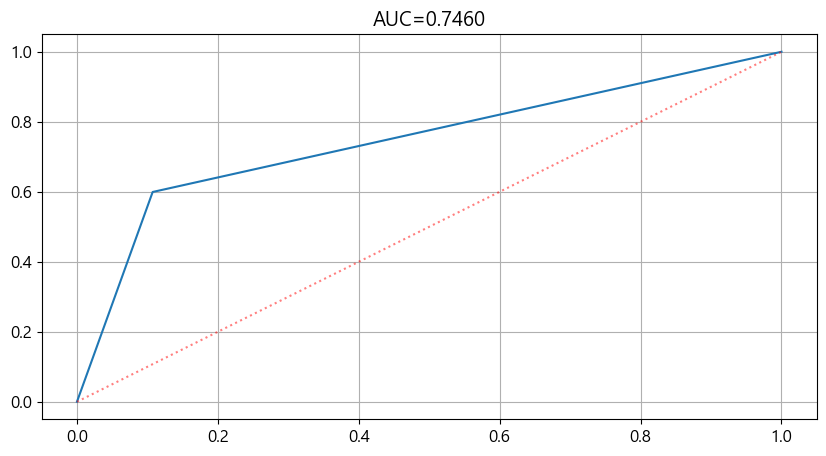

In [123]:
ras = roc_auc_score(df2['Survived'],df2['예측결과'])

# 위양성을 재현율 임계값(사용안함)
fpr,tpr,threshold = roc_curve(df2['Survived'],df2['예측결과'])

plt.figure()
sb.lineplot(x=fpr, y= tpr)
sb.lineplot(x=[0,1], y=[0,1],color = 'red', linestyle=':', alpha = 0.5)
plt.title('AUC={:.4f}'.format(ras))
plt.grid()
plt.show()
plt.close()

In [124]:
acc = accuracy_score(df2['Survived'], df2['예측결과'])

pre = precision_score(df2['Survived'], df2['예측결과'])

recall = recall_score(df2['Survived'], df2['예측결과'])

f1 = f1_score(df2['Survived'], df2['예측결과'])

fallout = fp/(fp+tn)

spe = 1- fallout

result_df = DataFrame({"설명력(Pseudo-Rsqe)":[fit.prsquared], "정확도(Accuracy)":[acc], "정밀도(Precision)":[pre], '재현율(Recall, TPR)':[recall], '위양성율(Fallout, FPR)': [fallout], '특이성(Specificity, TNR)':[spe], 'RAS': [ras], 'f1_score':[f1]})
result_df

,설명력(Pseudo-Rsqe),정확도(Accuracy),정밀도(Precision),"재현율(Recall, TPR)","위양성율(Fallout, FPR)","특이성(Specificity, TNR)",RAS,f1_score
0,0.341929,0.780022,0.776515,0.599415,0.107468,0.892532,0.745974,0.676568


## 데이터 전처리 후 제대로 다시하기

In [125]:
df = read_excel("https://data.hossam.kr/E05/titanic.xlsx")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 데이터 전처리
#### 결측치 확인

In [126]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### 결측치 정제
#### 객실 등급
선실이 부여되지 않은 경우 객실 등급에 따른 생존률에 변화가 있는지 확인해보자.

In [127]:
df_tmp = df.filter(['Pclass', 'Cabin']).query('Cabin.isnull()')
# df_tmp['Pclass'].value_counts()
df_tmp.fillna(0, inplace = True)
df_tmp.groupby('Pclass').count()

,Cabin
Pclass,
1,40
2,168
3,479


#### 객실 번호는 생존 여부에 영향이 없을 것으로 판단하고 변수 자체를 제거 (열단위 제거)

In [128]:
df1 = df.drop('Cabin', axis=1)
df1

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C


##### 탑승지
탑승지 데이터가 결측치인 경우는 2건 밖에 되지 않기 때문에 데이터 정제 과정에서 제거 (행단위)

또한 나이의 결측치를 어떻게 해결할 것인지 확인하기 위해 나이 결측치를 제외한 후 dataframe 생성

In [129]:
df2 = df1.query("Embarked.notnull() and Age.notnull()")
df2.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


#### 나이
연령 분포에 대한 커널밀도 그래프

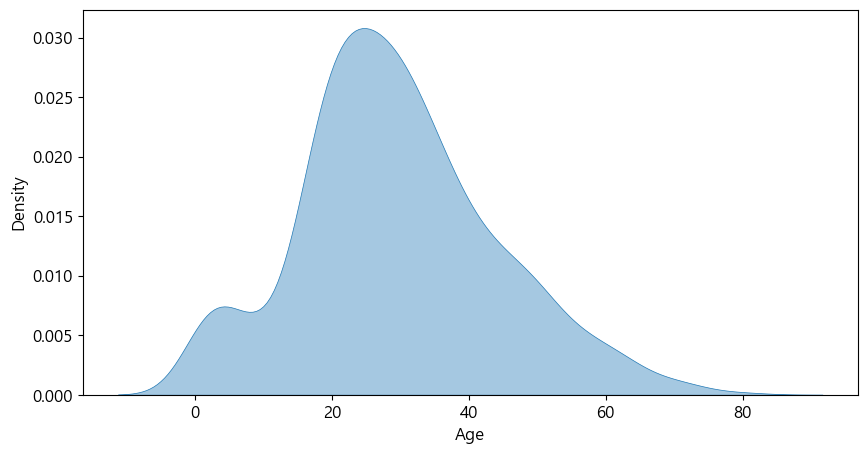

In [130]:
plt.rcParams["font.size"] = 12

plt.figure(figsize=(10, 5))
sb.kdeplot(data= df2, x='Age', fill=True, alpha=0.4, linewidth=.5)
plt.show()
plt.close()


>>20~40 사이의 연령층이 가장 많이 분포되어 있음을 알 수 있다. 60대 이상의 노년층 보다는 10세 이하의 어린이가 더 많이 탑승했음을 알 수 있다.

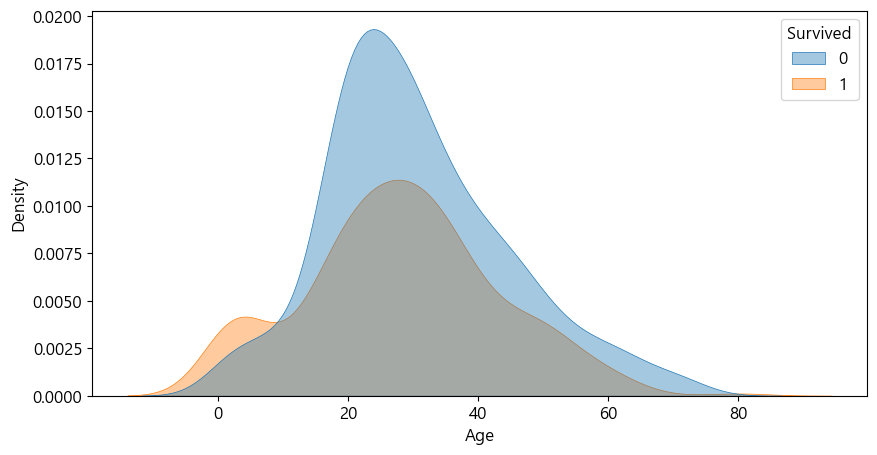

In [131]:
plt.rcParams["font.size"] = 12

plt.figure(figsize=(10, 5))
sb.kdeplot(data=df2, x='Age', hue='Survived', fill=True, alpha=0.4, linewidth=0.5)
plt.show()
plt.close()

어린이와 청소년층의 경우 사망자 대비 생존자가 더 많이 분포 된 것이 확인된다. 20세 이상~30세 정도의 연령층과 60세 이상의 노년층에서는 사망자가 더 많이 분포된 것이 확인된다.

위 내용으로 미루어 보아 나이는 생존 여부에 영향을 주는 요인으로 판단되어 결측치를 대체하기로 결정

### 나이를 중앙값으로 대체
나이의 경우 탑승객의 생존 여부에 중요한 영향을 미치는 요인이라고 짐작하고 삭제하지 않기로 결정하였다.

연속형 데이터의 결측치를 대체하기에 가장 적합한 값은 중앙값이므로 중앙값으로 대체한다

In [132]:
df3 = df2.copy()
df3['Age'].fillna(df['Age'].median(), inplace=True)
df3.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

#### 불필요한 필드 제거
탑승객 번호
탑승객 번호는 단순한 일련번호 이므로 생존률에 영향을 주지 않는 값이라고 판단하고 이 값을 인덱스로 설정하였다.

In [133]:
df4 = df3.set_index("PassengerId")
df4.head()


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
PassengerId,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


#### 이름과 티켓번호
#### 생존 여부에 영향을 주지 않는다고 판단하고 제거

In [134]:
df5 = df4.drop(['Name', 'Ticket'], axis=1)
df5.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


#### 더미변수 처리

In [135]:
cda_df = get_dummies(df5, columns= ['Pclass', 'Sex', 'Embarked'], drop_first=True, dtype="int")#첫번쨰 변수를 없애고 그 경우를 0으로 처리
cda_df.head()   #ex Pclass_1, Sex_female, Embarked_C 삭제

,Survived,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,
1,0,22.0,1,0,7.2500,0,1,1,0,1
2,1,38.0,1,0,71.2833,0,0,0,0,0
3,1,26.0,0,0,7.9250,0,1,0,0,1
4,1,35.0,1,0,53.1000,0,0,0,0,1
5,0,35.0,0,0,8.0500,0,1,1,0,1


#### 탐색적 데이터 분석을 위한 데이터 타입 변환
dummy 변수 처리 전 상태에서 명목형 변수를 category 타입으로 변환

In [136]:
eda_df = df5.astype({'Survived':'category', 'Pclass': 'category', 'Sex': 'category', 'Embarked': 'category'})
eda_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 1 to 891
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Survived  712 non-null    category
 1   Pclass    712 non-null    category
 2   Sex       712 non-null    category
 3   Age       712 non-null    float64 
 4   SibSp     712 non-null    int64   
 5   Parch     712 non-null    int64   
 6   Fare      712 non-null    float64 
 7   Embarked  712 non-null    category
dtypes: category(4), float64(2), int64(2)
memory usage: 31.1 KB


#### 탐색적 데이터 분석
기초 통계량 확인


In [137]:
eda_df.describe()

,Age,SibSp,Parch,Fare
count,712.000000,712.000000,712.000000,712.000000
mean,29.642093,0.514045,0.432584,34.567251
std,14.492933,0.930692,0.854181,52.938648
min,0.420000,0.000000,0.000000,0.000000
25%,20.000000,0.000000,0.000000,8.050000
50%,28.000000,0.000000,0.000000,15.645850
75%,38.000000,1.000000,1.000000,33.000000
max,80.000000,5.000000,6.000000,512.329200


각 요인간의 범위가 크게 다르기 때문에 데이터 표준화가 필요한 것으로 판단된다.

따라서 cateogry가 아닌 변수만 추출 후 표준화 진행

In [138]:
x_train_std_df, y_train_std_df =scailing(eda_df, "Survived")
x_train_std_df


,Age,SibSp,Parch,Fare
0,-0.527669,0.522511,-0.506787,-0.516380
1,0.577094,0.522511,-0.506787,0.694046
2,-0.251478,-0.552714,-0.506787,-0.503620
3,0.369951,0.522511,-0.506787,0.350326
4,0.369951,-0.552714,-0.506787,-0.501257
...,...,...,...,...
707,0.646142,-0.552714,5.350885,-0.102875
708,-0.182430,-0.552714,-0.506787,-0.407687
709,-0.734812,-0.552714,-0.506787,-0.086335
710,-0.251478,-0.552714,-0.506787,-0.086335


#### 더미 변수 생성
카테고리 변수들은 더미 변수를 생성한다

In [139]:
is_categorical(eda_df)

['Survived', 'Pclass', 'Sex', 'Embarked']

In [140]:
cda_df = get_dummies(eda_df[['Pclass', 'Sex', 'Embarked']], columns= ['Pclass', 'Sex', 'Embarked'], drop_first=True, dtype="int")#첫번쨰 변수를 없애고 그 경우를 0으로 처리
cda_df.reset_index(inplace=True), y_train_std_df.reset_index(inplace=True)
cda_df.drop('PassengerId',axis=1,inplace=True), y_train_std_df.drop("PassengerId",axis=1,inplace=True)
cda_df,y_train_std_df


(     Pclass_2  Pclass_3  Sex_male  Embarked_Q  Embarked_S
 0           0         1         1           0           1
 1           0         0         0           0           0
 2           0         1         0           0           1
 3           0         0         0           0           1
 4           0         1         1           0           1
 ..        ...       ...       ...         ...         ...
 707         0         1         0           1           0
 708         1         0         1           0           1
 709         0         0         0           0           1
 710         0         0         1           0           0
 711         0         1         1           1           0
 
 [712 rows x 5 columns],
     Survived
 0          0
 1          1
 2          1
 3          1
 4          0
 ..       ...
 707        0
 708        0
 709        1
 710        1
 711        0
 
 [712 rows x 1 columns])

둘을 합친다.,

In [141]:
final_df= concat([y_train_std_df,x_train_std_df,cda_df],axis=1)
final_df

,Survived,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S
0,0,-0.527669,0.522511,-0.506787,-0.516380,0,1,1,0,1
1,1,0.577094,0.522511,-0.506787,0.694046,0,0,0,0,0
2,1,-0.251478,-0.552714,-0.506787,-0.503620,0,1,0,0,1
3,1,0.369951,0.522511,-0.506787,0.350326,0,0,0,0,1
4,0,0.369951,-0.552714,-0.506787,-0.501257,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...
707,0,0.646142,-0.552714,5.350885,-0.102875,0,1,0,1,0
708,0,-0.182430,-0.552714,-0.506787,-0.407687,1,0,1,0,1
709,1,-0.734812,-0.552714,-0.506787,-0.086335,0,0,0,0,1
710,1,-0.251478,-0.552714,-0.506787,-0.086335,0,0,1,0,0


In [142]:
plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.unicode_minus"] = False

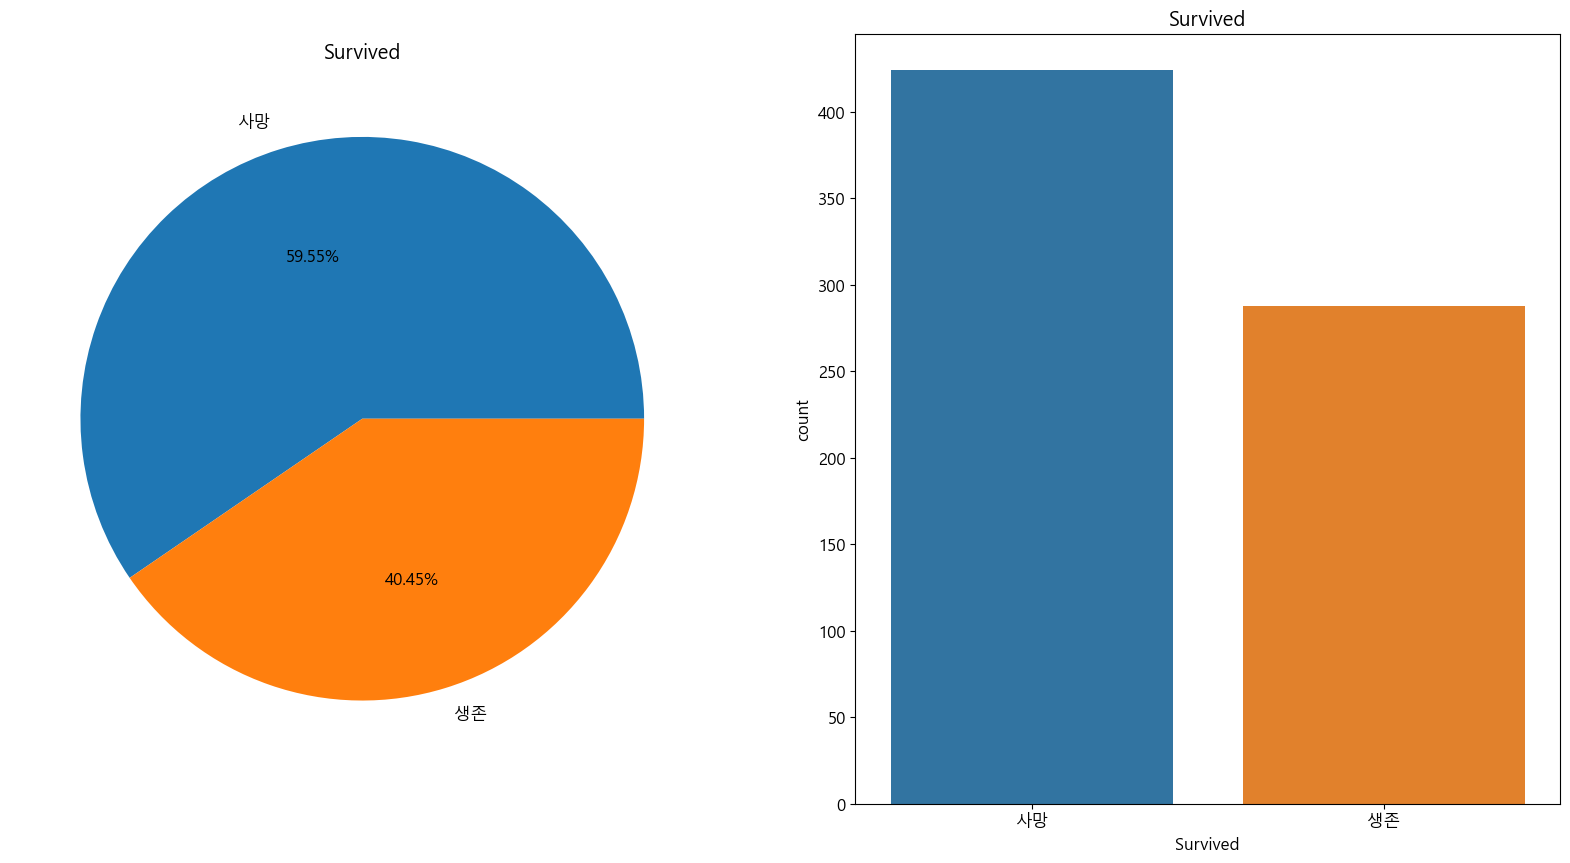

In [143]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), dpi=100)

vc = final_df['Survived'].value_counts()
ax1.pie(vc, labels=['사망', '생존'], autopct='%1.2f%%')
ax1.set_title('Survived')
ax1.set_ylabel('')

sb.countplot(x=final_df['Survived'], ax=ax2)
ax2.set_title('Survived')
ax2.set_xticks([0, 1])
ax2.set_xticklabels(['사망', '생존'])

plt.show()
plt.close()

In [144]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Survived    712 non-null    category
 1   Age         712 non-null    float64 
 2   SibSp       712 non-null    float64 
 3   Parch       712 non-null    float64 
 4   Fare        712 non-null    float64 
 5   Pclass_2    712 non-null    int32   
 6   Pclass_3    712 non-null    int32   
 7   Sex_male    712 non-null    int32   
 8   Embarked_Q  712 non-null    int32   
 9   Embarked_S  712 non-null    int32   
dtypes: category(1), float64(4), int32(5)
memory usage: 37.1 KB


#### 카테고리 변수 int로 변환

In [147]:
final_df['Survived']=final_df['Survived'].astype(int)

In [148]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    712 non-null    int32  
 1   Age         712 non-null    float64
 2   SibSp       712 non-null    float64
 3   Parch       712 non-null    float64
 4   Fare        712 non-null    float64
 5   Pclass_2    712 non-null    int32  
 6   Pclass_3    712 non-null    int32  
 7   Sex_male    712 non-null    int32  
 8   Embarked_Q  712 non-null    int32  
 9   Embarked_S  712 non-null    int32  
dtypes: float64(4), int32(6)
memory usage: 39.1 KB


In [149]:
x = list(final_df.columns)
x.remove('Survived')
logit_result = my_logit(final_df, y='Survived', x=x)
print(logit_result.summary)

Optimization terminated successfully.
         Current function value: 0.444060
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               Survived   No. Observations:                  712
Model:                          Logit   Df Residuals:                      702
Method:                           MLE   Df Model:                            9
Date:                Tue, 01 Aug 2023   Pseudo R-squ.:                  0.3419
Time:                        16:55:28   Log-Likelihood:                -316.17
converged:                       True   LL-Null:                       -480.45
Covariance Type:            nonrobust   LLR p-value:                 2.249e-65
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9866      0.353      8.454      0.000       2.294       3.679
Age           -0.6272      0.

In [150]:
logit_result.cmdf


,Positive,Negative
True,365,59
False,83,205


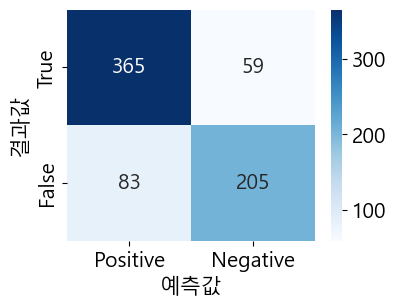

In [151]:
plt.rcParams["figure.figsize"] = (4, 3)
plt.rcParams["font.size"] = 15

sb.heatmap(logit_result.cmdf, annot = True, fmt = 'd',cmap = 'Blues')
plt.xlabel('예측값')
plt.ylabel('결과값')
plt.show()

In [152]:
logit_result.result_df


,설명력(Pseudo-Rsqe),정확도(Accuracy),정밀도(Precision),"재현율(Recall, TPR)","위양성율(Fallout, FPR)","특이성(Specificity, TNR)",RAS,f1_score
0,0.34193,0.800562,0.776515,0.711806,0.139151,0.860849,0.786327,0.742754


In [154]:
test_df = DataFrame({
    'dicaprio': [19, 0, 0, 0, 0, 1, 1, 1, 0],  # 영화속 남자 주인공 데이터
    'winslet': [17, 1, 1, 100, 0, 0, 0, 0, 1], # 영화속 여자 주인공 데이터
    'me': [27, 1, 0, 60, 1, 0, 1, 1, 0]  # 임의의 데이터
}, index=['Age', 'SibSp', 'Parch', 'Fare', 'Pclass_2', 'Pclass_3', 'Sex_male', 'Embarked_Q', 'Embarked_S'])

vdf = test_df.T
vdf

,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S
dicaprio,19,0,0,0,0,1,1,1,0
winslet,17,1,1,100,0,0,0,0,1
me,27,1,0,60,1,0,1,1,0


In [155]:
result = logit_result.fit.predict(vdf)
result

dicaprio    3.784807e-07
winslet     3.112467e-01
me          5.962666e-07
dtype: float64

In [157]:
for i, v in enumerate(result.index):
    print("%s님의 생존 확률은 %.2f%% 입니다." % (v, result[i]*100))

dicaprio님의 생존 확률은 0.00% 입니다.
winslet님의 생존 확률은 31.12% 입니다.
me님의 생존 확률은 0.00% 입니다.
